In [2]:
from shapely.wkt import dumps
from pyproj import CRS
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
from shapely import unary_union
from shapely.geometry import shape, mapping
from pymongo.errors import BulkWriteError
import matplotlib.pyplot as plt
import multiprocessing as mp
from pprint import pprint
from typing import Dict
import geopandas as gpd
from shapely import wkt
import pandas as pd
import numpy as np
import fiona
import os
import folium
import maup

# Useful functions

In [3]:
# Demographic Heat Map of Precincts
# + Election Results (Pres, Sen, Gov, etc.)
def block_to_precinct(block_data: gpd.GeoDataFrame,
                      precinct_data: gpd.GeoDataFrame):

    block_prec_assigns = maup.assign(block_data, precinct_data)
    return block_prec_assigns

def variable_grouping(assignment_data,
                      block_data,
                      precinct_data,
                      variables: list):
    precinct_data[variables] = block_data[variables].groupby(assignment_data).sum()
    return precinct_data

### Demographic Heat Map of Districts ###
def precinct_to_district(precinct_data: gpd.GeoDataFrame,
                      district_data: gpd.GeoDataFrame):
    prec_district_assigns = maup.assign(precinct_data, district_data)
    return prec_district_assigns

def geometry_to_wkt(geometry_data):
    """Convert a GeoDataFrame geometries to WKT format"""
    try:
        geometry_data['geometry'] = gpd.array.to_wkt(geometry_data['geometry'].values)
    except Exception as e:
        pprint(e)

    return geometry_data

def find_precinct_neighbors(precinct_data: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    '''Find the neighbors of each precinct in the precinct data and add it to the dataframe'''
    neighbors = maup.adjacencies(precinct_data)
    precinct_data['neighbors'] = neighbors
    return precinct_data

def rename_columns(dataframe: pd.DataFrame, columns_map) -> None:
    dataframe.rename(columns_map, inplace=True, axis=1)

def reorder_columns(dataframe: pd.DataFrame, columns: list):
    return dataframe[columns]

def fill_missing_pop_w_zero(dataframe: pd.DataFrame,
                                  name: str,
                                  column: pd.Series
                                  ) -> pd.Series:
    '''
    Randomly generating regions with a population of NaN
    using a gamma distribution which favors generating numbers at the lower range
    to prevent skewing our significant regions
    '''
    mean = column.mean()
    std = column.std()
    # adj_std = np.clip(std / 1000, 0, std)
    # adj_mean = np.clip(mean - std, 0, mean)
    is_null = column.isna()
    num_missing = is_null.sum()
    # maximum_acceptable_pop = dataframe[name].max()
    # pprint(mean, std, maximum_acceptable_pop)
    
    if num_missing > 0:
        # fill_values = np.random.default_rng().gamma(adj_mean, adj_std, num_missing)        
        # column[is_null] = np.clip(fill_values, 0, maximum_acceptable_pop)
        column[is_null] = 0
    return column

def calculate_state_wide_stats(dataframe: pd.DataFrame, columns) -> pd.DataFrame:
    return dataframe[columns].astype(int).sum()

def combine_election_results(block_df: pd.DataFrame, precinct_df: pd.DataFrame) -> pd.DataFrame:
    block_precinct_assign = maup.assign(block_df, precinct_df)
    columns = []
    aggregated_election_results = block_df.groupby(block_precinct_assign).sum()
    return aggregated_election_results

### TRANSFORM FUNCTIONS ###

def to_math_crs(geometry_data, crs=32030):
    geometry_data.to_crs(crs, inplace=True)
    return geometry_data

def to_world_crs(geometry_data, crs=4326):
    geometry_data.to_crs(crs, inplace=True)
    return geometry_data

def simplify_geometry(geometry_data):
    geometry_data['geometry'] = geometry_data['geometry'].simplify(0.001)
    return geometry_data

### Data Observation Functions ###
def common_columns(precinct_data: gpd.GeoDataFrame, block_data: gpd.GeoDataFrame) -> None:
    pprint(precinct_data.columns.intersection(block_data.columns))

def missing_data(precinct_data: gpd.GeoDataFrame) -> None:
    pprint(precinct_data.isna().sum())

def print_columns(precinct_data: gpd.GeoDataFrame) -> None:
    pprint(precinct_data.columns)

def print_df(precinct_data: gpd.GeoDataFrame) -> None:
    pprint(precinct_data.head())

def print_spacer() -> None:
    pprint('------------')

def print_crs(data: gpd.GeoDataFrame) -> None:
    pprint(data.crs)

In [4]:
# Get the current working directory
current_directory = os.getcwd()
move_up = os.path.dirname(os.path.dirname(current_directory))
data_dir = os.path.join(move_up, 'Data')
new_path = os.chdir(data_dir)
print(os.getcwd())

/Users/aaronlin/Downloads/Spring 2024/CSE 416/Data


# Nevada Preprocessing

### District-level data

Index(['DISTRICTNO', 'ADJPOP', 'TAWHITEALN', 'TABLACKCMB', 'TAAIANCMB',
       'TAASIANCMB', 'TANHOPICMB', 'TAOTHERALN', 'TA2RACE', 'TAHISPANIC',
       'VAPERSONS', 'TOTVOTER20', 'DEMVOTER20', 'REPVOTER20', 'NPVOTER20',
       'OTHVOTER20', 'PRES20_TOT', 'PRES20_DEM', 'PRES20_REP', 'PRES20_OTH',
       'AG18_TOTAL', 'AG18_DEM', 'AG18_REP', 'AG18_OTH', 'SOS18_TOTA',
       'SOS18_DEM', 'SOS18_REP', 'SOS18_OTH', 'PRES16_TOT', 'PRES16_DEM',
       'PRES16_REP', 'PRES16_OTH', 'geometry'],
      dtype='object')

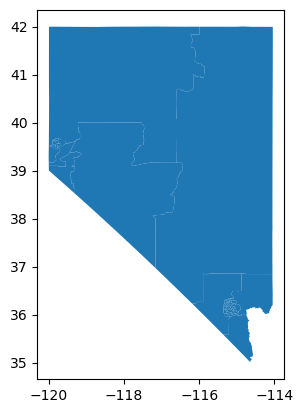

In [5]:
nv_district_df = gpd.read_file('NV Data/nv_sldl_2021/nv_sldl_2021.shp')

nv_district_df.plot()
display(nv_district_df.columns)

### Precinct-level Election Data

We begin by aggregating data on the precinct-level by merging Presidential data with Gubernational and US Senate

In [6]:
nv_2022_gen_elc = gpd.read_file('NV Data/nv_2022_gen_prec/nv_2022_gen_prec.csv')

# Gather US Senate
nv_gov_vote_2022 = nv_2022_gen_elc.iloc[:, :4].join(nv_2022_gen_elc.iloc[:, 12:16]).join(nv_2022_gen_elc.iloc[:, [39,43]])
# Removing Non-Democratic/Non-Republican votes
nv_gov_vote_2022.drop(['G22GOVOWRI', 'G22GOVLDAV'], axis=1, inplace=True)
nv_gov_vote_2022['PREC'] = nv_gov_vote_2022['PREC'].str.extract('(\\d+)').astype(float)
# # Some districts don't have numbers associated with them, when taking a closer look these districts
# # don't have any votes associated with them so we are safe to drop them
nv_gov_vote_2022.dropna(inplace=True)
nv_gov_vote_2022['PREC'] = nv_gov_vote_2022['PREC'].astype(int)
# # Creating a unique id to join the dataframes on
nv_gov_vote_2022['UNIQUE_ID'] = nv_gov_vote_2022['COUNTYFP'] + '-' + nv_gov_vote_2022['PREC'].astype(str)

Precinct-Level Gubernational and Attorney General Results from [Redistricting Data Hub](https://redistrictingdatahub.org/dataset/nevada-2022-general-election-precinct-level-results/)

In [44]:
nv_vest_shp = gpd.read_file('NV Data/nv_vest_20/nv_vest_20.shp')

nv_vest_shp = nv_vest_shp[nv_vest_shp['NAME'] != 'Voting Districts Not Defined']
# Formating unique id column as the gubernational election dataframe
nv_vest_shp['UNIQUE_ID'] = nv_vest_shp['COUNTY'] + '-' + nv_vest_shp['VTDST'].str.lstrip('0')

In [45]:
maup.doctor(nv_vest_shp)

/Users/aaronlin/anaconda3/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


There are 754 overlaps.
There are 2200 holes.


False

In [46]:
to_math_crs(nv_vest_shp)
nv_vest_shp = maup.smart_repair(nv_vest_shp)

Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 3250it [10:12,  5.30it/s]                                     
Gaps to fill: 100%|███████████████████████████| 289/289 [00:58<00:00,  4.92it/s]


In [10]:
maup.doctor(nv_vest_shp)

True

In [11]:
nv_vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTY', 'VTDST', 'NAME', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREIBLA', 'G20PREONON', 'geometry',
       'UNIQUE_ID'],
      dtype='object')

Precinct-Level Presidential Data from [Redistricting Data Hub](https://redistrictingdatahub.org/dataset/vest-2020-nevada-precinct-boundaries-and-election-results-shapefile/)

### Merging Presidential, Gubernational, Attornery General Elections by Precinct

Using an outer join and removing precincts with missing geometry

We need geometries do this in order to assign block data to precincts

In [12]:
nv_elections = pd.merge(nv_vest_shp, nv_gov_vote_2022, on='UNIQUE_ID', how='outer')

In [13]:
# Filter elections with geometry
nv_elections_precinct = gpd.GeoDataFrame(nv_elections[nv_elections.geometry != None])
nv_elections_precinct.reset_index(drop=True, inplace=True)

to_math_crs(nv_elections_precinct)
maup.doctor(nv_elections_precinct)

There are 95 overlaps.


False

In [14]:
unnecessary_columns = ['COUNTYFP_x', 'CNTY_NAME', 'PREC', 'COUNTYFP_y', 'COUNTY',
                       'VTDST', 'NAME', 'G20PRELJOR', 'G20PREIBLA', 'G20PREONON']

In [15]:
nv_elections_precinct.drop(unnecessary_columns, axis=1, inplace=True)

### Block-level Demographic data

We process the block data to be assigned to precinct-level data using the maup library

In [16]:
districtr_block_df = gpd.read_file('NV Data/districtr_nv_blockDemo/export-2657.shp')

Block-Level Demographic Data from [districtr](https://districtr.org/plan)

In [17]:
to_math_crs(nv_elections_precinct)

to_math_crs(districtr_block_df)

,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,HVAP,LOGRECNO,GEOCODE,SUMLEV,districtr,geometry
0,32,003,003249,2,320030032492,Block Group 2,G5030,S,689920,0,...,128,5,4,57,172,1465,320030032492,150,-1,"POLYGON ((-12730622.676 1592149.446, -12729865..."
1,32,003,003249,1,320030032491,Block Group 1,G5030,S,777076,0,...,168,10,9,88,159,1464,320030032491,150,-1,"POLYGON ((-12727670.004 1592245.200, -12727080..."
2,32,003,003251,2,320030032512,Block Group 2,G5030,S,461201,0,...,130,0,7,32,163,1469,320030032512,150,-1,"POLYGON ((-12723621.951 1590801.617, -12723599..."
3,32,003,003250,2,320030032502,Block Group 2,G5030,S,1494067,0,...,410,15,11,105,370,1467,320030032502,150,-1,"POLYGON ((-12731492.599 1589234.814, -12731259..."
4,32,003,003248,2,320030032482,Block Group 2,G5030,S,202841,0,...,92,2,7,31,179,1462,320030032482,150,-1,"POLYGON ((-12705251.225 1590854.349, -12705115..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,32,003,002997,2,320030029972,Block Group 2,G5030,S,980119,0,...,315,28,16,108,356,1350,320030029972,150,-1,"POLYGON ((-12720835.058 1563475.382, -12720594..."
1959,32,003,005721,1,320030057211,Block Group 1,G5030,S,1337028,0,...,120,3,9,28,44,2051,320030057211,150,-1,"POLYGON ((-12710395.296 1465107.111, -12710322..."
1960,32,003,005365,2,320030053652,Block Group 2,G5030,S,6229658,0,...,241,5,14,79,162,1960,320030053652,150,-1,"POLYGON ((-12676867.937 1473351.110, -12675827..."
1961,32,003,005869,1,320030058691,Block Group 1,G5030,S,665498,0,...,723,18,5,144,521,2151,320030058691,150,-1,"POLYGON ((-12745201.863 1540668.309, -12745016..."


In [18]:
nv_blocks_to_precinct_assignments = block_to_precinct(districtr_block_df, nv_elections_precinct)

In [19]:
districtr_block_df.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLKGRPCE20', 'GEOID20',
       'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20',
       'INTPTLAT20', 'INTPTLON20', 'TOTPOP', 'WHITE', 'BLACK', 'AMIN', 'ASIAN',
       'NHPI', 'OTHER', '2MORE', 'HISP', 'VAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'HVAP', 'LOGRECNO',
       'GEOCODE', 'SUMLEV', 'districtr', 'geometry'],
      dtype='object')

In [20]:
nv_block_columns = ['VAP', 'WVAP', 'BVAP', 'ASIANVAP', 'HVAP']
nv_elections_precinct = variable_grouping(assignment_data=nv_blocks_to_precinct_assignments,
                  block_data=districtr_block_df,
                  precinct_data=nv_elections_precinct,
                  variables=nv_block_columns)

In [21]:
maup.doctor(nv_elections_precinct)

There are 95 overlaps.


False

In [22]:
columns_to_fill = ['G22GOVDSIS', 'G22GOVRLOM', 'G22USSDCOR',
                   'G22USSRLAX', 'VAP', 'WVAP', 'BVAP', 'ASIANVAP', 'HVAP']
vote_results_to_int = ['G22GOVDSIS', 'G22GOVRLOM', 'G22USSDCOR', 'G22USSRLAX',
                       'G20PREDBID', 'G20PRERTRU', 'VAP', 'WVAP', 'BVAP', 'ASIANVAP', 'HVAP']

Before merging, some of the vote results were formatted as strings rather than integers. \
We reformat all of the voting results as integers for santiy and completeness.

In [23]:
for column in vote_results_to_int:
    nv_elections_precinct[column] = pd.to_numeric(nv_elections_precinct[column], errors='coerce')

Randomly generate missing values

In [24]:
for column_name in columns_to_fill:
    fill_missing_pop_w_zero(dataframe=nv_elections_precinct,
                                   name=column_name,
                                   column=nv_elections_precinct[column_name])

Some values came out as decimals! We can't have partial votes! \
We reformat values into whole integers again

In [25]:
nv_elections_precinct[columns_to_fill] = np.ceil(nv_elections_precinct[columns_to_fill]).astype(int)

We reorganize the column names for readiability and formatting

In [26]:
pct_votes = ['pct_wvap', 'pct_bvap', 'pct_asianvap', 'pct_hvap']

In [27]:
nv_elections_precinct[pct_votes] = (nv_elections_precinct[['WVAP', 'BVAP', 'ASIANVAP', 'HVAP']]
                                    .div(nv_elections_precinct['VAP'], axis=0)).astype(float)

In [28]:
vote_share = ['pct_bid', 'pct_tru', 'pct_cor', 'pct_lax']

nv_elections_precinct = nv_elections_precinct.assign(
                             pct_tru=lambda row: (row['G20PRERTRU'] / (row['G20PRERTRU'] + row['G20PREDBID'])).astype(float),
                             pct_bid=lambda row: (row['G20PREDBID'] / (row['G20PRERTRU'] + row['G20PREDBID'])).astype(float),
                             pct_cor=lambda row: (row['G22USSDCOR'] / (row['G22USSRLAX'] + row['G22USSDCOR'])).astype(float),
                             pct_lax=lambda row: (row['G22USSRLAX'] / (row['G22USSRLAX'] + row['G22USSDCOR'])).astype(float))

In [29]:
new_column_order = ['UNIQUE_ID', 'STATEFP', 'G20PREDBID', 'G20PRERTRU', 'G22USSDCOR', 'G22USSRLAX', 
                    'pct_bid', 'pct_tru', 'pct_cor', 'pct_lax', 'VAP', 'WVAP', 'BVAP', 'ASIANVAP', 
                    'HVAP', 'pct_wvap', 'pct_bvap', 'pct_asianvap', 'pct_hvap', 'geometry']
new_column_names = {
    'UNIQUE_ID': 'uniqueId',
    'STATEFP': 'state', 
    'G20PREDBID': 'PRE20D',
    'G20PRERTRU': 'PRE20R', 
    'G22USSDCOR': 'USS22D', 
    'G22USSRLAX': 'USS22R', 
    'VAP': 'vap', 
    'WVAP': 'wvap', 
    'BVAP': 'bvap', 
    'ASIANVAP': 'asianvap', 
    'HVAP': 'hvap',
    'pct_wvap' :'pct_wvap', 
    'pct_bvap' :'pct_bvap', 
    'pct_asianvap': 'pct_asianvap', 
    'pct_hvap': 'pct_hvap',
    'geometry': 'geometry'
}

nv_elections_precinct['STATEFP'] = 'Nevada'

nv_precinct_level_data = reorder_columns(dataframe=nv_elections_precinct, columns=new_column_order)
rename_columns(dataframe=nv_precinct_level_data, columns_map=new_column_names)

Because some of the areas have ZERO population, the dataframe results in NaN values, \
so we will fill them with 

In [30]:
nv_precinct_level_data[pct_votes] = nv_precinct_level_data[pct_votes].fillna(0)
nv_precinct_level_data[vote_share] = nv_precinct_level_data[vote_share].fillna(0)

In [31]:
pct_columns_to_int = ['pct_bid', 'pct_tru', 'pct_cor', 'pct_lax', 
                           'pct_wvap', 'pct_bvap', 'pct_asianvap', 'pct_hvap']

In [32]:
for column in pct_columns_to_int:
    nv_precinct_level_data[column] = nv_precinct_level_data[column].astype(float)

In [33]:
to_math_crs(nv_precinct_level_data)
maup.doctor(nv_precinct_level_data)

There are 95 overlaps.


False

In [34]:
nv_prec_adj = maup.adjacencies(nv_precinct_level_data)
nv_prec_adj

/Users/aaronlin/anaconda3/lib/python3.11/site-packages/maup/adjacencies.py:69: OverlapWarning: Found overlapping polygons while computing adjacencies.
This could be evidence of topological problems.
Indices of overlaps: {(2097, 2099), (2100, 2104), (2096, 2097), (2105, 2109), (2106, 2110), (2097, 2101), (2108, 2110), (1995, 1998), (2098, 2099), (2106, 2112), (2109, 2111), (2107, 2111), (2103, 2104), (2097, 2103), (2099, 2100), (2108, 2112), (1995, 2000), (2096, 2104), (2098, 2101), (2107, 2113), (1991, 1993), (2099, 2102), (2100, 2101), (2110, 2111), (1997, 1999), (1992, 1994), (2106, 2107), (2098, 2103), (2101, 2102), (2102, 2103), (2097, 2098), (2099, 2104), (2100, 2103), (1998, 2000), (2096, 2099), (2106, 2109), (2105, 2111), (2107, 2108), (2097, 2100), (2108, 2109), (1995, 1997), (2096, 2101), (2106, 2111), (2105, 2113), (2107, 2110), (2109, 2113), (2097, 2102), (90, 91), (2108, 2111), (1995, 1999), (1996, 1998), (2105, 2106), (2096, 2103), (2098, 2100), (2106, 2113), (2107, 2112),

0     2116    MULTILINESTRING ((-13082865.838 3420430.714, -...
      2117    MULTILINESTRING ((-13082865.838 3420430.714, -...
      1988    MULTILINESTRING ((-13090263.261 3468099.662, -...
      2034    MULTILINESTRING ((-13010961.386 3413141.451, -...
      2036    MULTILINESTRING ((-13068011.278 3323866.853, -...
                                    ...                        
2113  2114    MULTILINESTRING ((-13219616.629 3342923.944, -...
2114  2115    MULTILINESTRING ((-13272798.512 3301245.560, -...
      2116    MULTILINESTRING ((-13200555.513 3392428.958, -...
      2117    MULTILINESTRING ((-13200555.513 3392428.958, -...
2116  2117    POLYGON ((-13072265.730 3306634.463, -13072265...
Length: 5688, dtype: geometry

### Cleaning the district-level

In [35]:
nv_district_df.drop(['ADJPOP', 'TAWHITEALN', 'TABLACKCMB', 'TAAIANCMB',
       'TAASIANCMB', 'TANHOPICMB', 'TAOTHERALN', 'TA2RACE', 'TAHISPANIC',
       'VAPERSONS', 'TOTVOTER20', 'DEMVOTER20', 'REPVOTER20', 'NPVOTER20',
       'OTHVOTER20', 'PRES20_TOT', 'PRES20_DEM', 'PRES20_REP', 'PRES20_OTH',
       'AG18_TOTAL', 'AG18_DEM', 'AG18_REP', 'AG18_OTH', 'SOS18_TOTA',
       'SOS18_DEM', 'SOS18_REP', 'SOS18_OTH', 'PRES16_TOT', 'PRES16_DEM',
       'PRES16_REP', 'PRES16_OTH'], inplace=True, axis=1)

In [36]:
to_math_crs(nv_district_df)

,DISTRICTNO,geometry
0,1.0,"POLYGON ((-12663960.761 1628120.510, -12663822..."
1,2.0,"POLYGON ((-12743582.415 1586031.647, -12743130..."
2,3.0,"POLYGON ((-12699574.188 1601093.523, -12699423..."
3,4.0,"POLYGON ((-12711060.964 1619981.583, -12710861..."
4,5.0,"POLYGON ((-12728714.738 1576191.521, -12728607..."
5,6.0,"POLYGON ((-12683909.699 1580156.286, -12683885..."
6,7.0,"POLYGON ((-12684929.242 1588830.120, -12684859..."
7,8.0,"POLYGON ((-12737472.970 1534352.800, -12735772..."
8,9.0,"POLYGON ((-12752851.470 1559729.249, -12750721..."
9,10.0,"POLYGON ((-12714862.966 1568358.656, -12713506..."


In [37]:
precinct_to_district_assignment = maup.assign(nv_precinct_level_data, nv_district_df)
# Add the assigned districts as a column of the `precincts` GeoDataFrame:
nv_precinct_level_data["districtNum"] = precinct_to_district_assignment
precinct_to_district_assignment.head()

0    37
1    37
2    37
3    37
4    37
dtype: int64

In [38]:
nv_district_variables = ['PRE20D', 'PRE20R', 'USS22D', 'USS22R', 'vap', 'wvap', 'bvap', 'asianvap', 'hvap']
variable_grouping(assignment_data=precinct_to_district_assignment,
                  block_data=nv_precinct_level_data, 
                  precinct_data=nv_district_df,
                  variables=nv_district_variables)

nv_district_df[pct_votes] = (nv_district_df[['wvap', 'bvap', 'asianvap', 'hvap']].div(nv_district_df['vap'], axis=0)).astype(float)
nv_district_df['state'] = 'Nevada'
nv_district_df = nv_district_df.assign(
                             pct_rep=lambda row: (row['PRE20R'] / (row['PRE20R'] + row['PRE20D'])).astype(float),
                             pct_dem=lambda row: (row['PRE20D'] / (row['PRE20R'] + row['PRE20D'])).astype(float))

In [39]:
nv_district_df.columns

Index(['DISTRICTNO', 'geometry', 'PRE20D', 'PRE20R', 'USS22D', 'USS22R', 'vap',
       'wvap', 'bvap', 'asianvap', 'hvap', 'pct_wvap', 'pct_bvap',
       'pct_asianvap', 'pct_hvap', 'state', 'pct_rep', 'pct_dem'],
      dtype='object')

In [40]:
district_column_names = {
    'DISTRICTNO': 'districtNum'
}

rename_columns(dataframe=nv_district_df, columns_map=district_column_names)

In [41]:
for column in pct_votes:
    nv_district_df[column] = nv_district_df[column].astype(float)
for column in ['pct_rep', 'pct_dem']:
    nv_district_df[column] = nv_district_df[column].astype(float)

In [42]:
testing = nv_precinct_level_data.copy()

In [43]:
to_math_crs(testing, testing.estimate_utm_crs())

,uniqueId,state,PRE20D,PRE20R,USS22D,USS22R,pct_bid,pct_tru,pct_cor,pct_lax,...,wvap,bvap,asianvap,hvap,pct_wvap,pct_bvap,pct_asianvap,pct_hvap,geometry,districtNum
0,Churchill-14,Nevada,100.0,500.0,89,398,0.166667,0.833333,0.182752,0.817248,...,1087,4,13,144,0.816066,0.003003,0.009760,0.108108,"POLYGON ((335142.709 4343785.533, 335149.249 4...",37
1,Churchill-19,Nevada,117.0,504.0,99,375,0.188406,0.811594,0.208861,0.791139,...,609,6,6,83,0.799213,0.007874,0.007874,0.108924,"POLYGON ((320386.119 4378922.928, 320386.120 4...",37
2,Esmeralda-1,Nevada,36.0,179.0,29,142,0.167442,0.832558,0.169591,0.830409,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((462092.848 4182265.703, 462147.684 4...",37
3,Esmeralda-2,Nevada,4.0,42.0,4,32,0.086957,0.913043,0.111111,0.888889,...,449,1,4,108,0.753356,0.001678,0.006711,0.181208,"POLYGON ((462147.684 4182318.485, 462092.848 4...",37
4,Esmeralda-3,Nevada,30.0,165.0,32,162,0.153846,0.846154,0.164948,0.835052,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((432572.221 4156828.418, 432994.949 4...",37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,Lyon-1,Nevada,169.0,480.0,183,396,0.260401,0.739599,0.316062,0.683938,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((320442.068 4314904.336, 320435.447 4...",37
2114,Lyon-6,Nevada,319.0,968.0,202,356,0.247863,0.752137,0.362007,0.637993,...,670,4,5,187,0.740331,0.004420,0.005525,0.206630,"POLYGON ((333784.429 4264646.522, 333784.429 4...",37
2115,Lyon-8,Nevada,68.0,269.0,82,246,0.201780,0.798220,0.250000,0.750000,...,1303,11,9,360,0.733258,0.006190,0.005065,0.202589,"POLYGON ((333784.429 4264646.522, 333781.694 4...",37
2116,Lyon-5,Nevada,15.0,28.0,148,336,0.348837,0.651163,0.305785,0.694215,...,1780,18,12,306,0.746331,0.007547,0.005031,0.128302,"POLYGON ((348287.097 4326522.281, 348287.097 4...",37


In [1182]:
testing_repaired = maup.smart_repair(testing)

Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps...
Assigning order 2 pieces...
Couldn't find a polygon to glue a component in the intersection of geometries {2116, 2117} to
Couldn't find a polygon to glue a component in the intersection of geometries {90, 91} to
Assigning order 3 pieces...
Assigning order 4 pieces...
Couldn't find a polygon to glue a component in the intersection of geometries {1992, 1993, 1994, 1991} to
Assigning order 5 pieces...
Assigning order 6 pieces...
Couldn't find a polygon to glue a component in the intersection of geometries {2000, 1995, 1996, 1997, 1998, 1999} to
Assigning order 7 pieces...
Assigning order 8 pieces...
Assigning order 9 pieces...
Couldn't find a polygon to glue a component in the intersection of geometries {2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104} to
Couldn't find a polygon to glue a component in the intersection of geometries {2112, 2113, 2105, 2106, 21

Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


In [1183]:
maup.doctor(testing_repaired)

There are 2 holes.


False

In [1184]:
def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            # return MultiPolygon(Polygon(p.exterior) for p in poly)
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

def hole_func(poly: MultiPolygon):
    # eps = 0.01
    # omega = unary_union([
    #     Polygon(component.exterior).buffer(eps).buffer(-eps) for component in poly.geoms
    # ])
    return MultiPolygon(Polygon(p.exterior) for p in poly.geoms)

In [1186]:
testing_repaired = testing_repaired.geometry.apply(lambda p: hole_func(p) if p.geom_type == 'MultiPolygon' else close_holes(p))
# testing_repaired = testing_repaired.geometry.apply(lambda p: hole_func(p))

In [1187]:
maup.doctor(testing_repaired)

There are 116 overlaps.
There are 2 holes.


False

<Axes: >

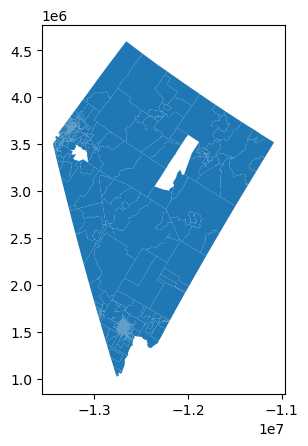

In [1188]:
testing_repaired.plot()

In [1189]:
testing_repaired2 = maup.smart_repair(testing_repaired)

Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps...
Assigning order 2 pieces...
2 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


In [1190]:
maup.doctor(testing_repaired2)

There are 2 holes.


False

In [1194]:
testing_repaired2 = testing_repaired2.geometry.apply(lambda p: hole_func(p) if p.geom_type == 'MultiPolygon' else close_holes(p))
# testing_repaired = testing_repaired.geometry.apply(lambda p: hole_func(p))

In [1195]:
maup.doctor(testing_repaired2)

There are 2 holes.


False

<Axes: >

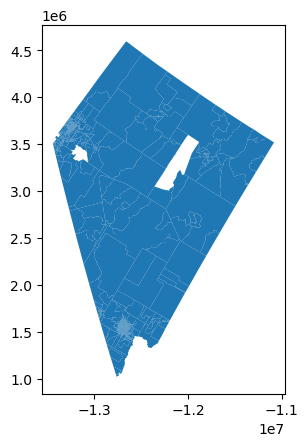

In [1196]:
testing_repaired2.plot()

In [1192]:
testing_repaired3 = maup.smart_repair(testing_repaired2)

Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps...
2 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


In [1075]:
# nv_district_df.to_file('nv_district_final_data.shp')
# nv_precinct_level_data.to_file('nv_precinct_final_data.shp')

/var/folders/7j/y8hy2rmn39l7q9f22wdvf5rr0000gn/T/ipykernel_28828/3754758534.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nv_district_df.to_file('nv_district_final_data.shp')
/var/folders/7j/y8hy2rmn39l7q9f22wdvf5rr0000gn/T/ipykernel_28828/3754758534.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nv_precinct_level_data.to_file('nv_precinct_final_data.shp')


In [ ]:
to_world_crs(nv_district_df)
to_world_crs(nv_precinct_level_data)

In [ ]:
simplify_geometry(nv_district_df)
simplify_geometry(nv_precinct_level_data)

In [ ]:
geometry_to_wkt(nv_district_df)
geometry_to_wkt(nv_precinct_level_data)

### Exporting Files

Before we export them we must simplifiy the geometry and turn them into WKT, we also format them into dictionaries to be sent to the database

In [974]:
# nv_district_df.to_file('nv_district_final_data.shp')
# nv_district_df.to_file('nv_district_final_data.geojson', driver='GeoJSON')
nv_district_df.to_csv('nv_district_final_data.csv', index=False)

In [975]:
# nv_precinct_level_data.to_file('nv_precinct_final_data.shp')
# nv_precinct_level_data.to_file('nv_precinct_final_data.geojson', driver='GeoJSON')
nv_precinct_level_data.to_csv('nv_precinct_final_data.csv', index=False)

# Mississippi Preprocessing

### Importing Block-level data

This data includes the demographic values on a block level collected MGGG's Districtr website source, which was sourced via the US Census Bureau

In [983]:
ms_districtr_block_df = gpd.read_file('MS Data/districtr_ms_blockDemo/export-3230.shp')

Block-Level Demographic Data from [districtr](https://districtr.org/plan)

In [984]:
to_math_crs(ms_districtr_block_df)

,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,HVAP,LOGRECNO,GEOCODE,SUMLEV,districtr,geometry
0,28,151,000300,3,281510003003,Block Group 3,G5030,S,2322883,0,...,0,0,0,6,3,3684,281510003003,150,-1,"POLYGON ((-5511001.592 -2209698.629, -5510804...."
1,28,151,001500,2,281510015002,Block Group 2,G5030,S,38328376,227053,...,7,0,0,13,13,3719,281510015002,150,-1,"POLYGON ((-5546486.069 -2240332.909, -5546470...."
2,28,151,000800,1,281510008001,Block Group 1,G5030,S,16951616,16692,...,14,0,0,22,11,3701,281510008001,150,-1,"POLYGON ((-5536686.909 -2242928.386, -5536665...."
3,28,151,001400,2,281510014002,Block Group 2,G5030,S,816612,0,...,0,0,0,4,1,3715,281510014002,150,-1,"POLYGON ((-5508667.705 -2222065.234, -5508528...."
4,28,151,000100,1,281510001001,Block Group 1,G5030,S,729919265,7673494,...,0,1,0,17,19,3678,281510001001,150,-1,"POLYGON ((-5489943.210 -2206802.150, -5489779...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,28,023,950201,2,280239502012,Block Group 2,G5030,S,107308151,363431,...,0,1,4,30,6,1561,280239502012,150,-1,"POLYGON ((-4922975.077 -2788058.383, -4922825...."
2441,28,023,950201,1,280239502011,Block Group 1,G5030,S,79891973,366607,...,1,0,0,17,2,1560,280239502011,150,-1,"POLYGON ((-4890956.464 -2797400.603, -4890947...."
2442,28,023,950201,3,280239502013,Block Group 3,G5030,S,25890533,309692,...,0,0,2,14,7,1562,280239502013,150,-1,"POLYGON ((-4901476.111 -2805535.039, -4901383...."
2443,28,023,950202,1,280239502021,Block Group 1,G5030,S,34870139,625672,...,0,0,0,8,2,1563,280239502021,150,-1,"POLYGON ((-4886610.436 -2822570.680, -4886598...."


In [985]:
ms_vest_20 = gpd.read_file('MS Data/ms_vest_20/ms_vest_20.shp')

"VEST Presidential Election Data from [Redistricting Hub](https://redistrictingdatahub.org/dataset/vest-2020-mississippi-precinct-and-election-results/) \
Precinct-Level Presidential Data + Geometry

In [986]:
to_math_crs(ms_vest_20)
ms_vest_repaired = maup.smart_repair(ms_vest_20)

Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.
Identifying overlaps...
Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to fill: 100%|███████████████████████████████| 3/3 [00:00<00:00, 11.54it/s]


In [1096]:
ms_vest_repaired['UNIQUE_ID'] = ms_vest_repaired['NAME20'] + '-' + ms_vest_repaired['VTDST20'].astype(str)

Dropping unused columns

In [1097]:
ms_unused_prec_col = [ 'G20PRELJOR', 'G20PREGHAW', 'G20PREABLA', 
                      'G20PREOCAR', 'G20PREIWES', 'G20PREICOL', 
                      'G20PREIPIE','G20USSLEDW', 'GEOID20']
pres_str_to_int = ['STATEFP20', 'COUNTYFP20', 'VTDST20']
ms_pres_20 = ms_vest_repaired.drop(ms_unused_prec_col, axis=1)
ms_pres_20[pres_str_to_int] = ms_pres_20[pres_str_to_int].astype(int)
ms_pres_20.sort_values(by='COUNTYFP20', inplace=True)

In [1098]:
ms_blocks_to_precinct_assignments = block_to_precinct(ms_districtr_block_df, ms_pres_20)

In [1099]:
nv_block_columns = ['VAP', 'WVAP', 'BVAP', 'ASIANVAP', 'HVAP']
ms_precinct_data = variable_grouping(assignment_data=nv_blocks_to_precinct_assignments,
                  block_data=districtr_block_df,
                  precinct_data=ms_pres_20,
                  variables=nv_block_columns)

We're starting to notice a pattern here with cleaning our data...

In [1100]:
columns_to_fill = ['VAP', 'WVAP', 'BVAP', 'ASIANVAP', 'HVAP']

In [1101]:
ms_precinct_data[columns_to_fill] = ms_precinct_data[columns_to_fill].fillna(0)
ms_precinct_data[columns_to_fill] = np.ceil(ms_precinct_data[columns_to_fill]).astype(int)

In [1102]:
ms_precinct_data[pct_votes] = (ms_precinct_data[['WVAP', 'BVAP', 'ASIANVAP', 'HVAP']]
                                    .div(ms_precinct_data['VAP'], axis=0)).astype(float)

In [1103]:
ms_precinct_data[pct_votes] = ms_precinct_data[pct_votes].fillna(0)

In [1104]:
vote_share = ['pct_bid', 'pct_tru', 'pct_hyd', 'pct_esp']

ms_precinct_data = ms_precinct_data.assign(
                             pct_tru=lambda row: (row['G20PRERTRU'] / (row['G20PRERTRU'] + row['G20PREDBID'])).astype(float),
                             pct_bid=lambda row: (row['G20PREDBID'] / (row['G20PRERTRU'] + row['G20PREDBID'])).astype(float),
                             pct_hyd=lambda row: (row['G20USSRHYD'] / (row['G20USSDESP'] + row['G20USSRHYD'])).astype(float),
                             pct_esp=lambda row: (row['G20USSDESP'] / (row['G20USSDESP'] + row['G20USSRHYD'])).astype(float))

In [1105]:
new_column_order = ['UNIQUE_ID', 'STATEFP', 'G20PREDBID', 'G20PRERTRU', 'G20USSDESP', 'G20USSRHYD', 
                    'pct_bid', 'pct_tru', 'pct_hyd', 'pct_esp', 'VAP', 'WVAP', 'BVAP', 'ASIANVAP', 
                    'HVAP', 'pct_wvap', 'pct_bvap', 'pct_asianvap', 'pct_hvap', 'geometry']
new_column_names = {
    'UNIQUE_ID': 'uniqueId',
    'STATEFP': 'state', 
    'G20PREDBID': 'PRE20D',
    'G20PRERTRU': 'PRE20R', 
    'G20USSDESP': 'USS20D', 
    'G20USSRHYD': 'USS20R', 
    'VAP': 'vap', 
    'WVAP': 'wvap', 
    'BVAP': 'bvap', 
    'ASIANVAP': 'asianvap', 
    'HVAP': 'hvap',
    'pct_wvap' :'pct_wvap', 
    'pct_bvap' :'pct_bvap', 
    'pct_asianvap': 'pct_asianvap', 
    'pct_hvap': 'pct_hvap',
    'geometry': 'geometry'
}

ms_precinct_data['STATEFP'] = 'Mississippi'

ms_precinct_level_data = reorder_columns(dataframe=ms_precinct_data, columns=new_column_order)
rename_columns(dataframe=ms_precinct_level_data, columns_map=new_column_names)
ms_precinct_level_data.reset_index(inplace=True)

In [1106]:
ms_precinct_level_data.columns

Index(['index', 'uniqueId', 'state', 'PRE20D', 'PRE20R', 'USS20D', 'USS20R',
       'pct_bid', 'pct_tru', 'pct_hyd', 'pct_esp', 'vap', 'wvap', 'bvap',
       'asianvap', 'hvap', 'pct_wvap', 'pct_bvap', 'pct_asianvap', 'pct_hvap',
       'geometry'],
      dtype='object')

### Importing Mississippi District Data

We only need the geometry and the District Num associated with it, so we drop everything else

In [1107]:
ms_districts_lower = gpd.read_file('MS Data/ms_sldl_adopted_2022/MS_HouseDists_Mar292022.shp')

District-level Data from [Redistricting Hub](https://redistrictingdatahub.org/dataset/2022-mississippi-senate-districts-approved-plan/)

In [1108]:
ms_districts_lower.drop(['ID', 'MEMBERS', 'LOCKED', 'NAME', 'POPULATION', 'WHITE', 'BLACK', 
                         'F18_POP', 'F18_WHT', 'F18_BLK', 'F18_AP_BLK', 'DEVIATION', 'F_DEVIATIO', 
                         'F_WHITE', 'F_BLACK', 'F_18_POP', 'F_18_WHT', 'F_18_BLK', 'MULTIPLE_F', 
                         'F_18_AP_BL', 'DISTRICT_L', 'Shade_Num', 'DISTRICT', 'AREA', 'IDEAL_VALU'], inplace=True, axis=1)

In [1109]:
to_math_crs(ms_districts_lower)

,Distnum,geometry
0,1,"POLYGON ((-4617675.501 -1798450.879, -4617657...."
1,2,"POLYGON ((-4625743.935 -1772237.728, -4625717...."
2,3,"POLYGON ((-4601978.778 -1978812.823, -4602026...."
3,4,"POLYGON ((-4780105.975 -1777388.784, -4779991...."
4,5,"POLYGON ((-4970927.462 -1755538.949, -4970828...."
...,...,...
117,119,"POLYGON ((-5097826.536 -3456329.024, -5097880...."
118,120,"POLYGON ((-5132081.830 -3511787.899, -5129547...."
119,121,"POLYGON ((-5129289.140 -3495134.848, -5129547...."
120,122,"POLYGON ((-5171829.696 -3448658.179, -5168604...."


In [1110]:
ms_precinct_to_district_assignment = maup.assign(ms_precinct_level_data, ms_districts_lower)
# Add the assigned districts as a column of the `precincts` GeoDataFrame:
ms_precinct_level_data["distrctNum"] = ms_precinct_to_district_assignment

In [1111]:
ms_district_variables = ['PRE20D', 'PRE20R', 'USS20D', 'USS20R',
                         'vap', 'wvap', 'bvap', 'asianvap', 'hvap']
ms_district_df = variable_grouping(assignment_data=ms_precinct_to_district_assignment,
                  block_data=ms_precinct_level_data, 
                  precinct_data=ms_districts_lower,
                  variables=ms_district_variables)

In [1112]:
ms_district_df[pct_votes] = (ms_district_df[['wvap', 'bvap', 'asianvap', 'hvap']].div(ms_district_df['vap'], axis=0)).astype(float)
ms_district_df['state'] = 'Mississippi'
ms_district_df = ms_district_df.assign(
                             pct_rep=lambda row: (row['PRE20R'] / (row['PRE20R'] + row['PRE20D'])).astype(float),
                             pct_dem=lambda row: (row['PRE20D'] / (row['PRE20R'] + row['PRE20D'])).astype(float))

In [1113]:
ms_district_df.columns

Index(['Distnum', 'geometry', 'PRE20D', 'PRE20R', 'USS20D', 'USS20R', 'vap',
       'wvap', 'bvap', 'asianvap', 'hvap', 'pct_wvap', 'pct_bvap',
       'pct_asianvap', 'pct_hvap', 'state', 'pct_rep', 'pct_dem'],
      dtype='object')

In [1114]:
new_column_order = ['Distnum', 'state', 'PRE20D', 'PRE20R', 'USS20D', 'USS20R', 'pct_rep', 'pct_dem', 'vap', 
                    'wvap', 'bvap', 'asianvap', 'hvap', 'pct_wvap', 'pct_bvap', 'pct_asianvap', 'pct_hvap', 'geometry']

district_column_names = {
    'Distnum': 'districtNum'
}

ms_district_df = reorder_columns(dataframe=ms_district_df, columns=new_column_order)
rename_columns(dataframe=ms_district_df, columns_map=district_column_names)
ms_district_df.sort_values(by='districtNum', inplace=True)

In [1117]:
ms_district_df.to_file('ms_district_final_data.shp')
ms_precinct_level_data.to_file('ms_precinct_final_data.shp')

/var/folders/7j/y8hy2rmn39l7q9f22wdvf5rr0000gn/T/ipykernel_28828/3340539031.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ms_district_df.to_file('ms_district_final_data.shp')
/var/folders/7j/y8hy2rmn39l7q9f22wdvf5rr0000gn/T/ipykernel_28828/3340539031.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ms_precinct_level_data.to_file('ms_precinct_final_data.shp')


In [1095]:
to_world_crs(ms_district_df)
to_world_crs(ms_precinct_level_data)

,index,uniqueId,state,PRE20D,PRE20R,USS20D,USS20R,pct_bid,pct_tru,pct_hyd,...,wvap,bvap,asianvap,hvap,pct_wvap,pct_bvap,pct_asianvap,pct_hvap,geometry,distrctNum
0,139,Morgantown-000405,Mississippi,352,106,362,99,0.768559,0.231441,0.214751,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((-91.33804 31.59586, -91.33781 31.595...",92
1,138,Northside School-000401,Mississippi,1062,58,1069,55,0.948214,0.051786,0.048932,...,1291,3,8,114,0.841591,0.001956,0.005215,0.074316,"POLYGON ((-91.40701 31.56919, -91.40776 31.569...",92
2,122,By-Pass Firestation-000102,Mississippi,521,262,539,248,0.665390,0.334610,0.315121,...,437,11,15,100,0.724710,0.018242,0.024876,0.165837,"POLYGON ((-91.42313 31.50167, -91.42315 31.501...",94
3,123,Courthouse-000101,Mississippi,185,399,199,385,0.316781,0.683219,0.659247,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((-91.39589 31.54052, -91.39673 31.540...",95
4,124,Duncan Park-000202,Mississippi,387,466,410,432,0.453693,0.546307,0.513064,...,798,0,2,80,0.845339,0.000000,0.002119,0.084746,"MULTIPOLYGON (((-91.37858 31.53672, -91.37843 ...",92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,891,Valley-000109,Mississippi,21,157,33,144,0.117978,0.882022,0.813559,...,484,61,101,130,0.601242,0.075776,0.125466,0.161491,"POLYGON ((-90.43728 32.76199, -90.43718 32.761...",52
1760,890,Ward 2 Welfare Office-000204,Mississippi,221,127,238,115,0.635057,0.364943,0.325779,...,725,78,108,171,0.615973,0.066270,0.091759,0.145285,"POLYGON ((-90.39991 32.85521, -90.40008 32.855...",49
1761,889,3-2 Old Jr. High-000302,Mississippi,467,80,495,58,0.853748,0.146252,0.104882,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((-90.41407 32.84650, -90.41375 32.847...",49
1762,500,Fugates-000104,Mississippi,180,197,185,189,0.477454,0.522546,0.505348,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((-90.31540 32.66580, -90.31527 32.665...",52


In [ ]:
simplify_geometry(ms_district_df)
simplify_geometry(ms_precinct_level_data)

In [ ]:
geometry_to_wkt(ms_district_df)
geometry_to_wkt(ms_precinct_level_data)

### Exporting Mississippi Data

Just like before, we export the data to a csv for convenience

In [1033]:
ms_district_df.to_csv('ms_district_final_data.csv')
ms_precinct_level_data.to_csv('ms_precinct_final_data.csv')

### Assigning Demographic data on the Block Level to Election Results on the Precinct Level

Using the Maup library we assign blocks to precincts

In [823]:
test = gpd.read_file('NV Data/nv_sldl_2021/nv_sldl_2021.shp')

test.to_excel('nv_districts.xlsx')